In [1]:
import torch
import torchvision
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
torch.cuda.get_device_name(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def howmuchmem():
    print(f"Total memory: {torch.cuda.get_device_properties(device).total_memory//(1024*1024)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(device)//(1024*1024)}")
    print(f"Memory cached: {torch.cuda.memory_reserved(device)//(1024*1024)}")
howmuchmem()

Total memory: 6143
Memory allocated: 0
Memory cached: 0


Files already downloaded and verified


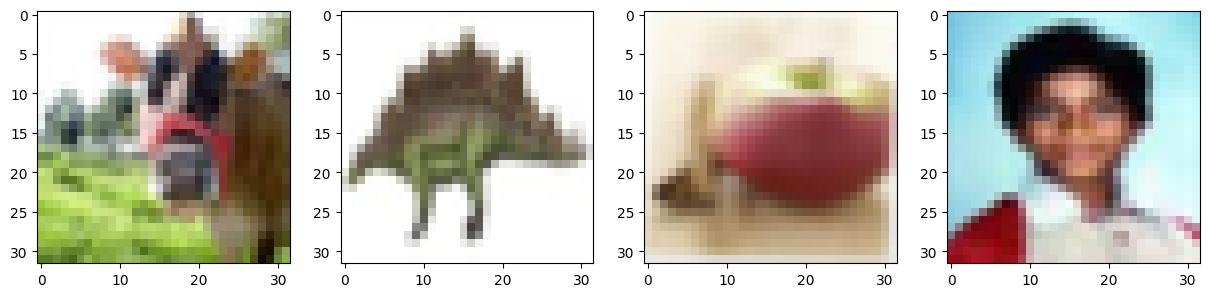

In [3]:
def show_image(data, num_samples=4, cols=4):
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples//cols + 1, cols, i+1)
        plt.imshow(img[0])

data = torchvision.datasets.CIFAR100(root='.', download=True)
show_image(data)

In [4]:
# Create a linear noise scheduler
# beta varies from 0.0001 to 0.02
# so alpha varies from 1-beta=0.9999 to 0.98
timesteps = 300
starting_beta = 0.0001
ending_beta = 0.02
beta = torch.linspace(starting_beta, ending_beta, timesteps)
alpha =  1 - beta
alpha_tau = torch.cumprod(alpha, 0)
alpha_tau_1 = torch.nn.functional.pad(alpha_tau[:-1], (0,1), value=1.0)
variance = beta * (1-alpha_tau_1) / (1-alpha_tau)
batch_size = 2
IMG_SIZE = 64

In [5]:
def reshape_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) -1))).to(t.device)

In [6]:
def apply_noise(xo, t, device = 'cuda'):
    # It calculates the noise image
    t = t.to(device)
    xo = xo.to(device)
    noise = torch.randn_like(xo)
    mean = torch.mul(torch.sqrt(reshape_from_list(alpha_tau, t, xo.shape)), xo).to(device)
    var = torch.mul((1-reshape_from_list(alpha_tau, t, xo.shape)), noise).to(device)
    noise = noise.to(device)
    return mean + var, noise

d:\Programmazione\Miniconda\envs\aienv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid rang

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


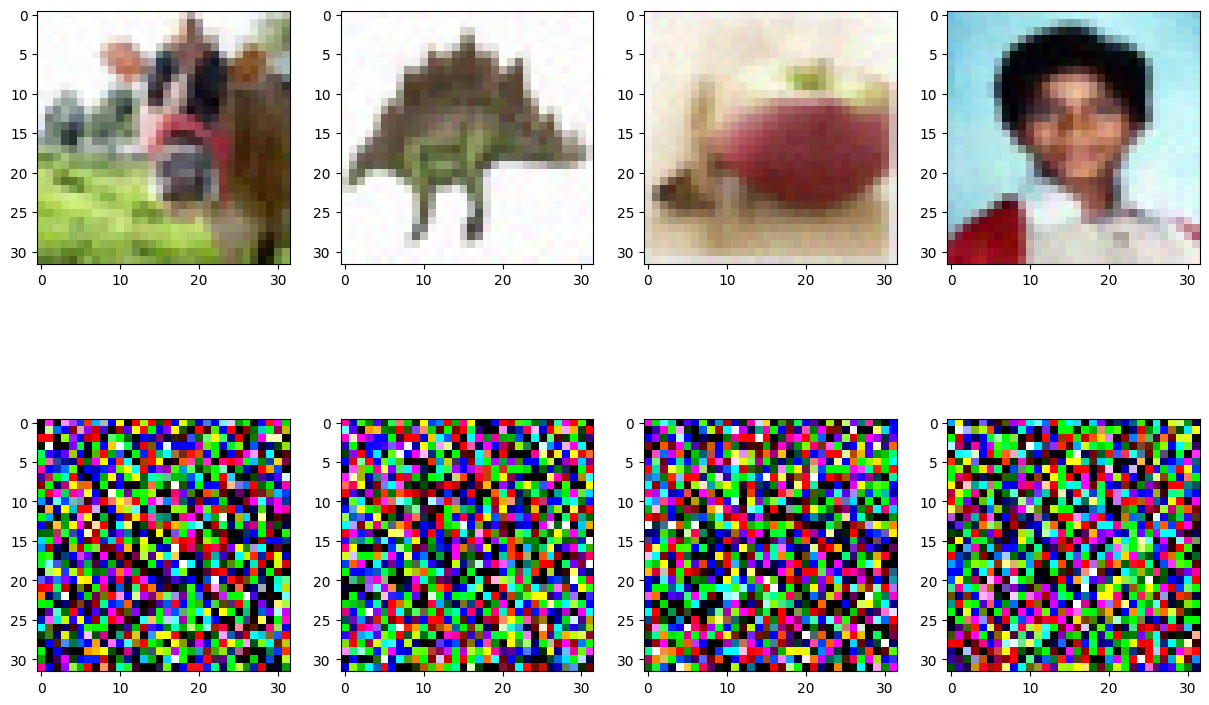

In [7]:
def show_noised_image(data, num_samples=4, cols=4, t=torch.Tensor([20]).type(torch.int64)):
    plt.figure(figsize=(15,15))
    trans = v2.Compose([v2.ToTensor()])
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples//cols + 2, cols, i+1)
        x = trans(img[0])
        plt.imshow(apply_noise(x, t, 'cpu')[0].permute(1,2,0))
        plt.subplot(num_samples//cols + 2, cols, i+1+cols)
        plt.imshow(apply_noise(x, torch.Tensor([299]).type(torch.int64), 'cpu')[0].permute(1,2,0))

show_noised_image(data)

In [8]:
howmuchmem()

Total memory: 6143
Memory allocated: 0
Memory cached: 0


In [9]:
from torch.utils.data.dataloader import default_collate

def get_transform(size=(IMG_SIZE, IMG_SIZE)):
    transformations = [
        v2.Resize(size),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,)*3, std=(0.5,)*3) # x_n = (x - mu)/std = x/std - mu/std = x*2 - 1 (inverse: (x_n + 1)/2 )
    ]
    transform = v2.Compose(transformations)
    return transform

def get_train_dataloader(transform, device='cuda'):
    data = torchvision.datasets.CIFAR100(root='.', download=True, transform=transform)
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    return data_loader

def from_tensor_to_img(tensor):
    # Tensor is between -1 and 1
    transformations = [
        v2.Lambda(lambda img: (img+1)/2),
        v2.ToPILImage()
    ]
    transform = v2.Compose(transformations)
    return transform(tensor)

train_dataloader = get_train_dataloader(get_transform())

Files already downloaded and verified


In [10]:
howmuchmem()

Total memory: 6143
Memory allocated: 0
Memory cached: 0


C:\Users\kingpowa\AppData\Local\Temp\ipykernel_25280\188619434.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, idx+1)


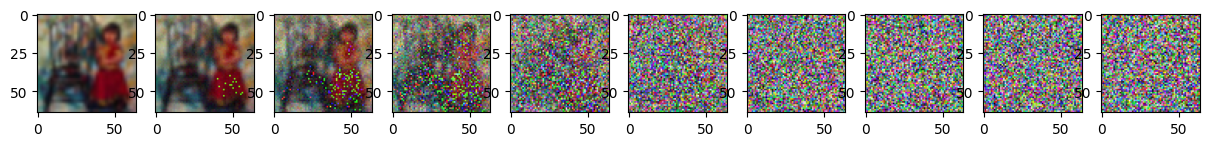

In [11]:
# Apply denoising

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
image = next(iter(train_dataloader))[0][0, :, :, :]

num_of_steps = torch.arange(0, timesteps+1, step=timesteps//(num_images-1))
for idx, t in enumerate(num_of_steps):
    plt.subplot(1, num_images, idx+1)
    t = torch.Tensor([t]).type(torch.int64)
    img_noise = apply_noise(image, t, 'cpu')
    img_py = from_tensor_to_img(img_noise)[0]
    plt.imshow(img_py)

In [12]:
# Create the U-Net model
from torch import nn

# Swish
class Swish(nn.Module):

    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(x)
    
# Time Embeddings
class TimeEmbeddings(nn.Module):

    def __init__(self, n_dim: int):
        
        super().__init__()

        self.n_dim = n_dim

        self.linear1 = nn.Linear(self.n_dim//4, self.n_dim)
        self.swish = Swish()
        self.linear2 = nn.Linear(self.n_dim, self.n_dim)

    def forward(self, t: torch.Tensor):

        single_emb_dim = self.n_dim // 4
        embedding = torch.exp(torch.arange(single_emb_dim) * -(torch.log(torch.Tensor([10000])) / (single_emb_dim - 1))).to('cuda')
        embedding = t[:, None] * embedding[None, :]

        return self.linear2(self.swish(self.linear1(embedding)))
        

# Residual -> DownSample -> Residual -> DownSample -> Middle -> Upsample -> ...
class Residual(nn.Module):

    def __init__(self, in_channels, out_channels, time_channels = 10, n_groups=32, dropout=True, norm_before_act=False):
        
        super().__init__()
        # Convo -> Normalisation -> Activation
        if dropout: self.dropout = nn.Dropout()
        else: self.dropout = nn.Identity()

        # H X W X in_channels -> H X W X out_channels
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), padding=(1,1))
        self.action1 = nn.GroupNorm(n_groups, out_channels) if not norm_before_act else Swish()
        self.action2 = Swish() if not norm_before_act else nn.GroupNorm(n_groups, out_channels)
        # H X W X out_channels -> H X W X out_channels
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), padding=(1,1))
        self.action3 = nn.GroupNorm(n_groups, out_channels) if not norm_before_act else nn.Sequential(self.dropout, Swish())
        self.action4 = nn.Sequential(self.dropout, Swish()) if not norm_before_act else nn.GroupNorm(n_groups, out_channels)

        # Residual 
        self.shortcut = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1))

        # time_channels -> out_channels and expanded on H, W
        self.linear_for_time = nn.Linear(time_channels, out_channels)
        self.act_for_time = Swish()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        
        res = self.conv1(x)
        res = self.action1(res)
        res = self.action2(res)
        time_res = self.linear_for_time(self.act_for_time(t))
        res += time_res[:,:,None,None]
        res = self.conv2(res)
        res = self.action3(res)
        res = self.action4(res)

        return res + self.shortcut(x)
    
class Attention(nn.Module):

    def __init__(self, n_channels, n_heads: int = 1, dims = 10):

        super().__init__()
        
        self.n_heads = n_heads
        self.dims = dims
        self.scale = dims ** -0.5

        self.project = nn.Linear(n_channels, n_heads * 3 * dims)
        self.trns_output = nn.Linear(n_heads*dims, n_channels)

    def forward(self, x: torch.Tensor, t):

        _ = t
        b_size, n_channels, height, width = x.shape
        # Prepare x for projection 
        # B x C x H x W -> B x C x (H+W) -> B x (H+W) x C
        xu = x.view(b_size, n_channels, -1).permute(0,2,1)
        # Projection size -> B (Batch) x (H+W) x H' (heads) + D (dimensions) * 3 (query, key, vector). Unsqueeze to B x (H+W) x H' x D*3 And then separate to three B x (H+W) x H' x D
        projection = self.project(xu).view(b_size, -1, self.n_heads, 3*self.dims)
        del xu
        query, key, value = torch.chunk(projection, 3, dim=-1)
        # Compute score -> s_bijh measure score between the element i of q and j of k over all h heads, summing over the d dimension. Scaling on the sqrt(d)
        score = torch.einsum('bihd,bjhd->bijh', query, key) * self.scale
        # Compute softmax along (H+W) dim -> B x (H+W) x H' x D
        score = score.softmax(dim=2)
        # Multiply the "score" for the "value" summing their product on the seq
        wg = torch.einsum('bijd,bjhd->bihd', score, value)
        # Squeeze as we did before projecting
        wg = wg.view(b_size, -1, self.n_heads*self.dims)
        # Transform to "input" -> b_size, (H+W), n_channels -> b_size, n_channels, (H+W) and reshape
        wg = self.trns_output(wg).permute(0,2,1)
        wg = wg.view(b_size, n_channels, height, width)
        # Skip
        return wg + x
    
class DownBlock(nn.Module):

    def __init__(self, in_channels, out_channels, time_channels = 10, n_groups=32, dropout=True, norm_before_act=False, has_attention = True, n_heads: int = 1, dims = 10):

        super().__init__()
        self.residual = Residual(in_channels=in_channels, out_channels=out_channels, time_channels=time_channels, n_groups=n_groups, dropout=dropout, norm_before_act=norm_before_act)
        self.attention = Attention(out_channels, n_heads, dims) if has_attention else nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.residual(x, t)
        x = self.attention(x, t)
        return x
    
class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels, time_channels = 10, n_groups=32, dropout=True, norm_before_act=False, has_attention = True, n_heads: int = 1, dims = 10):

        super().__init__()
        self.residual = Residual(in_channels=in_channels*2, out_channels=out_channels, time_channels=time_channels, n_groups=n_groups, dropout=dropout, norm_before_act=norm_before_act)
        self.attention = Attention(out_channels, n_heads, dims) if has_attention else nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.residual(x, t)
        x = self.attention(x, t)
        return x
    
class MidBlock(nn.Module):

    def __init__(self, n_channels, time_channels = 10, n_groups=32, dropout=True, norm_before_act=False, has_attention = True, n_heads: int = 1, dims = 10):

        super().__init__()
        self.residual1 = Residual(in_channels=n_channels, out_channels=n_channels, time_channels=time_channels, n_groups=n_groups, dropout=dropout, norm_before_act=norm_before_act)
        self.attention = Attention(n_channels, n_heads, dims) if has_attention else nn.Identity()
        self.residual2 = Residual(in_channels=n_channels, out_channels=n_channels, time_channels=time_channels, n_groups=n_groups, dropout=dropout, norm_before_act=norm_before_act)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.residual1(x, t)
        x = self.attention(x, t)
        x = self.residual2(x, t)
        return x

class Upsample(nn.Module):

    def __init__(self, n_channels):

        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(3,3), padding=(1,1))


    def forward(self, x: torch.Tensor, t):
        _ = t
        x = self.upsample(x)
        x = self.conv(x)
        return x
    
class Downsample(nn.Module):

    def __init__(self, n_channels):

        super().__init__()
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(3,3), stride=(2,2), padding=(1,1))


    def forward(self, x: torch.Tensor, t):
        _ = t
        x = self.conv(x)
        return x

In [13]:
class UNet(nn.Module):

    def __init__(self, img_channels = 3, n_blocks = 2, n_channels = 64, mul_resolutions = (1,2)):

        super().__init__()
        
        self.time_embedding = TimeEmbeddings(n_dim=n_channels*4)
        self.input_layer = nn.Conv2d(in_channels=img_channels, out_channels=n_channels, kernel_size=(3,3), padding=(1,1))

        n_resolutions = len(mul_resolutions)

        self.down = nn.ModuleList()

        in_channels = out_channels = n_channels

        for i in range(n_resolutions):

            out_channels = n_channels * mul_resolutions[i]
            
            for j in range(n_blocks):
                self.down.append(DownBlock(in_channels=in_channels, out_channels=out_channels, time_channels=n_channels*4))
                in_channels = out_channels

            if i < n_resolutions-1:
                self.down.append(Downsample(in_channels))

        self.middle = MidBlock(out_channels, time_channels=n_channels*4)

        self.up = nn.ModuleList()

        in_channels = out_channels

        for i in range(n_resolutions-1,-1,-1):
            
            for j in range(n_blocks-1):
                self.up.append(UpBlock(in_channels=in_channels, out_channels=out_channels, time_channels=n_channels*4))
                in_channels = out_channels

            out_channels = out_channels // mul_resolutions[i]
            self.up.append(UpBlock(in_channels=in_channels, out_channels=out_channels, time_channels=n_channels*4))
            in_channels = out_channels

            if i > 0:
                self.up.append(Upsample(in_channels))

        self.gropnorm = nn.GroupNorm(8, n_channels)
        self.swish = Swish()
        self.final = nn.Conv2d(in_channels, img_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):

        
        t = self.time_embedding(t)
        x = self.input_layer(x)

        identities = [x]

        for down_layer in self.down:
            x = down_layer(x, t)
            if not isinstance(down_layer, Downsample):
                identities.append(x)

        x = self.middle(x,t)

        for up_layer in self.up:
            if isinstance(up_layer, Upsample):
                x = up_layer(x, t)
            else:
                skip = identities.pop()
                # Attach skip connection to second dimension (H)
                x = up_layer(torch.cat((x,skip), dim=1), t)

        return self.final(self.swish(self.gropnorm(x)))


In [14]:
unet = UNet(img_channels=3, n_blocks=2, n_channels=64, mul_resolutions=(1,2))
print(sum(p.numel() for p in unet.parameters()))

2622225


In [15]:
unet

UNet(
  (time_embedding): TimeEmbeddings(
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (swish): Swish()
    (linear2): Linear(in_features=256, out_features=256, bias=True)
  )
  (input_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (residual): Residual(
        (dropout): Dropout(p=0.5, inplace=False)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (action1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (action2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (action3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (action4): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Swish()
        )
        (shortcut): Identity()
        (linear_for_time): Linear(in_features=256, out_features=64, bias=True)
        (act_for_time): Swish()
      )
      (attention)

In [16]:
howmuchmem()

Total memory: 6143
Memory allocated: 0
Memory cached: 2


In [17]:
def noise_loss(model: nn.Module, xo: torch.Tensor, t: torch.Tensor, device='cuda'):
    x_t, noise = apply_noise(xo, t, device)
    pred = model(x_t, t)
    return torch.nn.functional.mse_loss(noise, pred)

In [18]:
@torch.no_grad()
def sample(x_t, t):
    scaling_factor = reshape_from_list(alpha, t, x_t.shape) ** -0.5
    noise_scaling_factor = (1 - reshape_from_list(alpha, t, x_t.shape)) * ((1 - reshape_from_list(alpha_tau, t, x_t.shape))**-0.5)
    mean_t_1 =  scaling_factor * (x_t - noise_scaling_factor * unet(x_t, t))
    variance_t_1 = 0 if t == 0 else torch.sqrt(reshape_from_list(variance, t, x_t.shape)) * torch.randn_like(x_t)
    return mean_t_1 + variance_t_1

@torch.no_grad()
def show_sample(device):
    img_size = IMG_SIZE
    img = torch.randn((1,3,img_size, img_size)).to(device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    stepsize = timesteps // 10

    idx = 1
    for i in range(timesteps-1,-1,-1):
        t = torch.Tensor([i]).type(torch.long).to(device)
        img = sample(img, t)
        if i % stepsize == 0:
            plt.subplot(1, 10, idx)
            idx += 1
            plt.imshow(from_tensor_to_img(img.view(3,img_size,img_size)))
    plt.show()

Files already downloaded and verified


C:\Users\kingpowa\AppData\Local\Temp\ipykernel_25280\355977510.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 10, idx)


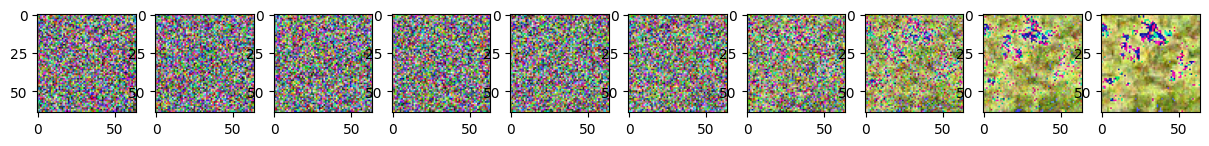

Epoch 1 | step 000/25000 Loss: 0.021763868629932404 
Epoch 1 | step 2500/25000 Loss: 0.21610090136528015 
Epoch 1 | step 5000/25000 Loss: 0.9901266098022461 
Epoch 1 | step 7500/25000 Loss: 1.003338098526001 
Epoch 1 | step 10000/25000 Loss: 0.989326000213623 
Epoch 1 | step 12500/25000 Loss: 1.0003427267074585 
Epoch 1 | step 15000/25000 Loss: 0.9696054458618164 
Epoch 1 | step 17500/25000 Loss: 0.9793221950531006 
Epoch 1 | step 20000/25000 Loss: 1.0031342506408691 
Epoch 1 | step 22500/25000 Loss: 0.9967941045761108 
Files already downloaded and verified
Epoch 2 | step 000/25000 Loss: 0.9909552931785583 
Epoch 2 | step 2500/25000 Loss: 1.002790927886963 
Epoch 2 | step 5000/25000 Loss: 1.0023610591888428 
Epoch 2 | step 7500/25000 Loss: 0.9870819449424744 
Epoch 2 | step 10000/25000 Loss: 0.992091178894043 
Epoch 2 | step 12500/25000 Loss: 0.9848647117614746 
Epoch 2 | step 15000/25000 Loss: 0.9749765396118164 
Epoch 2 | step 17500/25000 Loss: 1.0027661323547363 
Epoch 2 | step 2000

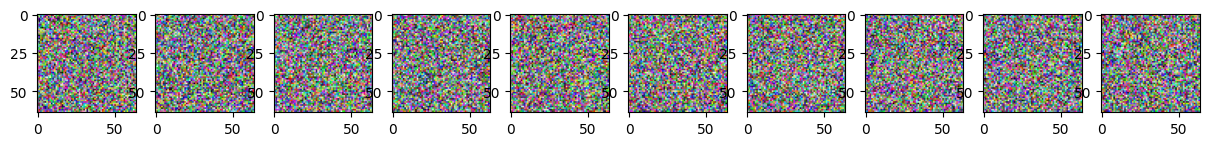

Epoch 6 | step 000/25000 Loss: 0.9999389052391052 
Epoch 6 | step 2500/25000 Loss: 0.9937993884086609 
Epoch 6 | step 5000/25000 Loss: 1.004118800163269 
Epoch 6 | step 7500/25000 Loss: 1.0020761489868164 
Epoch 6 | step 10000/25000 Loss: 1.008849859237671 
Epoch 6 | step 12500/25000 Loss: 1.0090171098709106 
Epoch 6 | step 15000/25000 Loss: 1.0073800086975098 
Epoch 6 | step 17500/25000 Loss: 0.9992709159851074 
Epoch 6 | step 20000/25000 Loss: 1.0023226737976074 
Epoch 6 | step 22500/25000 Loss: 1.0021226406097412 
Files already downloaded and verified
Epoch 7 | step 000/25000 Loss: 1.0071020126342773 
Epoch 7 | step 2500/25000 Loss: 0.9889101386070251 
Epoch 7 | step 5000/25000 Loss: 1.002138376235962 
Epoch 7 | step 7500/25000 Loss: 1.0013878345489502 
Epoch 7 | step 10000/25000 Loss: 0.9964577555656433 
Epoch 7 | step 12500/25000 Loss: 0.9904765486717224 
Epoch 7 | step 15000/25000 Loss: 1.0006989240646362 
Epoch 7 | step 17500/25000 Loss: 1.0084155797958374 
Epoch 7 | step 20000/

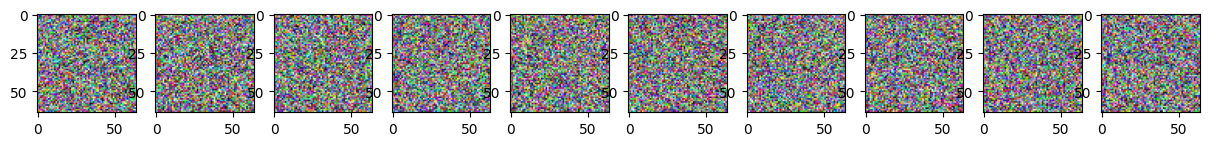

Epoch 11 | step 000/25000 Loss: 0.9951775074005127 
Epoch 11 | step 2500/25000 Loss: 0.99345862865448 
Epoch 11 | step 5000/25000 Loss: 0.9866043925285339 
Epoch 11 | step 7500/25000 Loss: 1.001355528831482 
Epoch 11 | step 10000/25000 Loss: 1.0092694759368896 
Epoch 11 | step 12500/25000 Loss: 1.0029327869415283 
Epoch 11 | step 15000/25000 Loss: 0.9920162558555603 
Epoch 11 | step 17500/25000 Loss: 0.9955706596374512 
Epoch 11 | step 20000/25000 Loss: 1.0067607164382935 
Epoch 11 | step 22500/25000 Loss: 1.0002857446670532 
Files already downloaded and verified
Epoch 12 | step 000/25000 Loss: 1.008932113647461 
Epoch 12 | step 2500/25000 Loss: 1.0060091018676758 
Epoch 12 | step 5000/25000 Loss: 0.9975157976150513 
Epoch 12 | step 7500/25000 Loss: 0.9970699548721313 
Epoch 12 | step 10000/25000 Loss: 1.0004137754440308 
Epoch 12 | step 12500/25000 Loss: 1.0033783912658691 
Epoch 12 | step 15000/25000 Loss: 1.0062823295593262 
Epoch 12 | step 17500/25000 Loss: 1.0027682781219482 
Epoc

In [24]:
from torch.optim import Adam
unet.to('cuda')
optimizer = Adam(unet.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    data_loader = get_train_dataloader(get_transform(size=(IMG_SIZE, IMG_SIZE)), 'cuda')
    steps = len(data_loader)
    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (batch_size,), device='cuda').long()

        loss = noise_loss(unet, batch[0], t, device='cuda')
        loss.backward()
        optimizer.step()

        if epoch%5 == 0 and step == 0:
            show_sample(device)
        
        if step % 2500 == 0:
            print(f"Epoch {epoch+1} | step {step:03d}/{steps} Loss: {loss.item()} ")

In [41]:
a = torch.zeros([2, 1024, 64]).permute(0,2,1)
a.view(2,64,32,32).shape

torch.Size([2, 64, 32, 32])

In [ ]:
a = torch.Tensor([[[1,2,3],[3,4,4]],[[5,6,5],[7,8,6]]])
a.softmax(dim=2), a.shape

In [ ]:
a = torch.Tensor([1,2,3,4,5,6]).reshape(1,6)
t = torch.empty((5, 6))
print(a.shape, t.shape)
torch.gather(a, -1, t.long())